# Libraries

Import your libraries

In [1]:
import numpy as np
import pandas as pd
import statistics as cal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix, confusion_matrix

# Importing Data

Import the CSV file with Actions, Sum and Div as a Dataframe called df. Fill the empty values of Action with 0. 
Replace NaN values with 0. Delete first 100 rows. 

In [2]:
#load in df
Player = 15
Game = 2

df = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_Action.csv')

# Fill NaN with 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0)

#Convert Sprinting to 1
df.Action[df.Action == "Sprinting"] = 1

#Delete first 99 rows, so df starts at timeLine == 1.00
df = df.iloc[99: , :]

<ipython-input-2-e044bac9e483>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Action[df.Action == "Sprinting"] = 1


# Preparing Data

Split the Dataframe in chunks van n/100 seconden. Combine to 1 dataframe. With Sum,Div and Action split into Train and Valid/Test. 

In [3]:
#Convert data into chunks of a second
n = 100 #chunk size (100 datapoints in one second)
chunks = [df[i:i+n] for i in range(0,df.shape[0],n)]

#Set chunks into dataframe
#for chunk in chunks:
frames = []
for chunk in chunks:
    P = pd.DataFrame({'Frames':[chunk['Unnamed: 0'].tolist()], 'frAcc':[max(chunk['frAcc'].tolist())], 
                      'frRoAcc':[chunk['frRoAcc'].tolist()], 'frDispl':[chunk['frDispl'].tolist()], 
                      'frRoAng':[chunk['frRoAng'].tolist()], 'frSpeed':[max(chunk['frSpeed'].tolist())], 
                      'timeLine':[max(chunk['timeLine'].tolist())], 'frameRotationalSpeedX':[chunk['frameRotationalSpeedX'].tolist()], 
                      'frameRotationalSpeedY':[chunk['frameRotationalSpeedY'].tolist()], 'frameRotationalSpeedZ':[cal.mean(chunk['frameRotationalSpeedZ'].tolist())],
                      'wheelRotationalSpeedX':[max(chunk['wheelRotationalSpeedX'].tolist())], 'wheelRotationalSpeedY':[chunk['wheelRotationalSpeedY'].tolist()],
                      'wheelRotationalSpeedZ':[chunk['wheelRotationalSpeedZ'].tolist()], 'frRoSpeed':[max(chunk['frRoSpeed'].tolist())],
                      'Sum_WheelX_FrameZ':[max(chunk['Sum_WheelX_FrameZ'].tolist())], 'Div_FrameZ_WheelX':[cal.mean(chunk['Div_FrameZ_WheelX'].tolist())],
                      'Filt_WheelX':[cal.mean(chunk['Filt_WheelX'].tolist())], 'Filt_FrameZ':[cal.mean(chunk['Filt_FrameZ'].tolist())],
                      'Action':[max(chunk['Action'].tolist())]})
    frames.append(P)

df = pd.concat(frames,ignore_index=True)

In [4]:
# split chunk data into train test validate (with colum [sum and Div] as input, and action as output)
X_train, X_test, y_train, y_test = train_test_split(df[[
                                                        'Sum_WheelX_FrameZ',
                                                        'Div_FrameZ_WheelX',
                                                        'wheelRotationalSpeedX',
                                                        'Filt_FrameZ',
                                                        'Filt_WheelX',
                                                       ]], 
                                                    df.Action, test_size = 0.2, random_state=42)

# Fitting Model

Choose a classification model. Train model with Training data.

In [5]:
#Nearest Neighbors
model1 = KNeighborsClassifier(n_neighbors=15)
model1.fit(X_train,y_train)

#Decision tree
model2 = DecisionTreeClassifier(random_state = 6, max_depth = 2, min_samples_leaf = 0.04 , max_features = 0.4, class_weight='balanced')
model2.fit(X_train,y_train)

#SVC
#model3 = SVC(kernel = 'linear', gamma= 1e-05)
#model3.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=2, max_features=0.4,
                       min_samples_leaf=0.04, random_state=6)

# Gridsearch toepassen


In [6]:
#tree_model_1 = KNeighborsClassifier()
tree_model_2 = DecisionTreeClassifier(random_state=6)
#tree_model_3 = SVC()
# creating an array for different n_neighbours parameter
#param_grid_model_1 = {'n_neighbors' : [ 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}
param_grid_model_2 = {'max_depth': [1, 2, 3, 4, 5, 6] , 'min_samples_leaf': [0.04, 0.06, 0.08, 0.1, 0.12], 'max_features': [0.2, 0.4, 0.6, 0.8], 'class_weight': ['balanced']} 
#param_grid_model_3 = {'kernel': ['linear', 'rbf', 'poly'], 'gamma' : [0.1, 0.3, 0.7, 1, 1.5, 2, 5, 10] , 'C' : [0.1, 0.5, 1, 5, 10, 20]}
#knn_cv = []

#for i in range(10):
tree = GridSearchCV(tree_model_2,param_grid_model_2)
tree = tree.fit(X_train,y_train)
print(tree.best_params_)
#print(tree.best_score_)
#print("Test accuracy of best grid search hypers:", tree.score(X_test, y_test))

{'class_weight': 'balanced', 'max_depth': 2, 'max_features': 0.6, 'min_samples_leaf': 0.1}


# Validate/Tune Model

Validate results of the model (Precision/Recall). Tune the parameters of the model to achieve better results

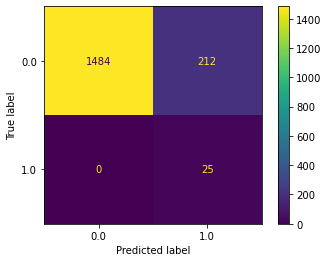

In [7]:
#GridsearchCV Polynomials
plot_confusion_matrix(tree, X_test, y_test)
plt.show()

# Export Data

Export the results in CSV format. Layout = Time,Action

In [8]:
X_test['Action'] = tree.predict(X_test)

In [9]:
X_test = X_test.sort_index()
df_test = X_test[X_test['Action']==1]
df_test.index

Int64Index([ 346,  736,  737, 2111, 2114, 2115, 2127, 2138, 2177, 2199,
            ...
            7952, 7953, 7970, 7976, 7988, 8012, 8020, 8022, 8038, 8041],
           dtype='int64', length=237)

In [10]:
Sprint = []
for i in range(1,len(df_test['Action']),1):  #stappen van 2 
    if df_test.index[i]-df_test.index[i-1] > 3:
        Sprint.append(df_test.index[i-1])
        
Sprint = pd.DataFrame(Sprint,columns=['Time'])
Sprint

,Time
0,346
1,737
2,2115
3,2127
4,2138
...,...
151,7970
152,7976
153,7988
154,8012


In [11]:
Sprint.to_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_FoundSprints.csv')